<h1><center>DSA 4212: Year 2022</center></h1>
<h3><center> Assignment 2 (Deadline: Sunday 27th March at 23:59) </center></h3>
<h4><center> Group Number: XX </center></h4>
<h4><center> Filename: assignment_2_XX.ipynb where XX is your group number</center></h4>
<h4><center> Group Member 1: XXX, XXX </center></h4>
<h4><center> Group Member 2: XXX, XXX </center></h4>
<h4><center> Group Member 3: XXX, XXX </center></h4>
<h4><center> Group Member 4: XXX, XXX </center></h4>

**Remark:** as described below, each group has to submit two documents on lumiNUS: 
1. a jupyter notebook with your code  
2. a pdf report explaining your approaches and conclusions.
3. you can have a look at `https://www.overleaf.com/read/xmvqgpsdqwyx` if you would like to use Overleaf and Latex to rapidly produce a neat report. You can use your NUS email to create an Overleaf account.

**File naming convention:**
1. the Jupyter notebook needs to be named `assignment_2_XX.ipynb`. For example, group number 3 needs to name its jupyter notebook as `assignment_2_03.ipynb`.
1. the pdf report needs to be named `assignment_2_XX.pdf`. For example, group number 3 needs to name its pdf report as `assignment_2_03.pdf`.



In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
%matplotlib inline
from jax.config import config
config.update("jax_enable_x64", True) # for higher accuracy

import jax
import jax.numpy as jnp

import pylab as plt
import imageio
import os
import numpy as np
# to install scikit-image: !pip install scikit-image
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd
import scipy
import copy
from skimage import exposure
from sklearn.model_selection import train_test_split
import time
from functools import reduce
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

from collections import Counter
from tqdm import tqdm
from scipy.sparse import csr_matrix
import math
import operator
from sklearn.preprocessing import normalize

from numpy.linalg import norm
from random import normalvariate
from math import sqrt


import random
import os

import time


### Random Seed

In [3]:
np.random.seed(1)

# Load Dataset

In [4]:
path_csv  = "./drive/MyDrive/DSA4212/ml-1m"


## Load Movies

In [5]:
movies = pd.read_csv(os.path.join(path_csv,'movies.dat'), sep = "::", header=None, encoding = 'ISO-8859-1',names = ["MovieID","Title","Genres"]) 

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [6]:
movies = pd.read_csv(os.path.join(path_csv,'movies.dat'), sep = "::", header=None, encoding = 'ISO-8859-1',names = ["MovieID","Title","Genres"]) 

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [7]:
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
movie_dict = { row[0]: (row[1], set(row[2].lower().split('|'))) for row in movies.values}

## Load Ratings

In [9]:
ratings = pd.read_csv(os.path.join(path_csv,'ratings.dat'), sep = "::", header=None, names = ["UserID","MovieID","Rating","Timestamp"])

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [10]:
ratings

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


## Load Users

In [11]:
users = pd.read_csv(os.path.join(path_csv,'users.dat'), sep = "::", header=None, names = ["UserID","Gender","Age","Occupation","Zip-code"]) 

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [12]:
users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [13]:
movies.shape, ratings.shape, users.shape

((3883, 3), (1000209, 4), (6040, 5))

In [14]:
movie_ids = movies['MovieID'].unique()
num_movie = len(movie_ids)
user_ids = ratings['UserID'].unique()
num_user = len(user_ids)

def id_transform(ids):
  id2idx, idx2id = {}, {}

  for idx, item_id in enumerate(ids):
      id2idx[item_id] = idx
      idx2id[idx] = item_id

  return id2idx, idx2id


In [15]:
movie_id2idx, movie_idx2id = id_transform(movie_ids)
user_id2idx, user_idx2id = id_transform(user_ids)

## Initial User-Item Matrix

In [16]:
M = np.zeros((num_user, num_movie))

print('The User-Item Matrix M has shape of {}'.format(M.shape))

The User-Item Matrix M has shape of (6040, 3883)


In [17]:
def ini_matrix(ratings, user_id2idx, movie_id2idx):
  for index, row in ratings.iterrows():
      user_id, movie_id, rating = row['UserID'], row['MovieID'], row['Rating']

      user_idx = user_id2idx[user_id]
      movie_idx = movie_id2idx[movie_id]
      
      M[user_idx][movie_idx] = rating
  return M
M = ini_matrix(ratings, user_id2idx, movie_id2idx)


In [18]:
num_nonzero = np.count_nonzero(M > 0)
percent_sparsity = num_nonzero / np.prod(M.shape) * 100

print('Number of non-zero entries in M: {} (sparsity: {:.3f}%)'.format(num_nonzero, percent_sparsity))

Number of non-zero entries in M: 1000209 (sparsity: 4.265%)


## Split training and test set

In [19]:
def train_test_split(ratings):
    ratings = ratings.T
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for movie in range(ratings.shape[0]):
      movie_nonzero = ratings[movie,:].nonzero()[0]
      test_ratings = np.random.choice(movie_nonzero,size=round(0.1*len(movie_nonzero)),replace=False)
      train[movie, test_ratings] = 0.
      test[movie, test_ratings] = ratings[movie, test_ratings]
        
    assert(np.all((train * test) == 0)) 
    return train.T, test.T
train, test = train_test_split(M)



# Tasks
1. Implement a collaborative filtering algorithm (from scratch) on the MovieLens 1M Dataset available here.
2. For evaluating your method, you will use a random training set containing 90% of the available ratings and
will report the Root Mean Squared Error (RMSE) on the remaining 10%.
3. You are encouraged to try several approaches and read the relevant recent literature on the problem. 

## Tools

### Euclidean Similarity

In [ ]:
def get_distance(data1, data2):
  points = zip(data1, data2)
  diffs_squared_distance = [pow(a - b, 2) for (a, b) in points]
  return math.sqrt(sum(diffs_squared_distance))

get_distance(M[0],M[1])

51.0

In [ ]:
get_distance(M[1],M[6039])

73.61385739111897

### Jaccard Similarity

In [ ]:
user1 = M[0]!=0
user2 = M[1]!=0

def Jac_sim(x,y):

  up = np.double(np.bitwise_and((x!=y),np.bitwise_or(x!=0,y!=0)).sum())
  down = np.double(np.bitwise_or(x!=0,y!=0).sum())

  return up/down

Jac_sim(user1,user2)

0.96

In [ ]:
user3 = M[6039]!=0
Jac_sim(user3,user2)

0.8888888888888888

### Consine Similarity

In [ ]:
cosine_similarity(np.matrix(M[0]),np.matrix(M[1]))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


array([[0.09638153]])

In [ ]:
cosine_similarity(np.matrix(M[1]),np.matrix(M[6039]))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


array([[0.21827563]])

### Pearson Correlation

In [ ]:
np.corrcoef(M[0],M[1])

array([[1.        , 0.07780405],
       [0.07780405, 1.        ]])

In [ ]:
np.corrcoef(M[1],M[6039])

array([[1.        , 0.17862702],
       [0.17862702, 1.        ]])

### Mean rating scores*

In [31]:
masked = np.ma.masked_equal(M, 0)
movie_mean_ratings = np.mean(masked, axis=0)
user_mean_ratings = np.mean(masked, axis=1).reshape(-1, 1)

### Min-Max Rescale*

In [22]:
def rescale_rating(a,max_rate, min_rate):
  a_std = (a-np.min(a))/(np.max(a)-np.min(a))
  a_scaled = a_std*(max_rate - min_rate) + min_rate
  return a_scaled

### Evaluation Metric*

In [23]:
def rmse(y_true, y_pred):
  y_pred = y_pred[y_true.nonzero()].flatten()
  y_true = y_true[y_true.nonzero()].flatten()
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  scale = np.sqrt(np.mean(y_true**2))
  return rmse

In [24]:
def fast_rate(M,mode='user',sim_type='cos',top_k=50):
  if mode == 'user':
    u_sim = user_similarities.copy()
    u_sim[u_sim<0]=0
    if sim_type == 'cos':
      index = np.argsort(u_sim,axis=1)[:,:-top_k]
    elif sim_type == 'euc':
      index = np.argsort(u_sim,axis=1)[:,top_k:]
    for user_similarity, index_new in zip(u_sim,index):
      user_similarity[index_new] = 0
    return np.dot(u_sim,M)/np.array([np.abs(u_sim).sum(axis=1)-1]).T

  elif mode == 'item':
    item_sim = np.copy(movie_similarities)
    item_sim[item_sim<0]=0
    if sim_type == 'cos':
      index = np.argsort(item_sim,axis=1)[:,:-top_k]
    elif sim_type == 'euc':
      index = np.argsort(item_sim,axis=1)[:,top_k:]
    for movie_similarity, index_new in zip(item_sim,index):
      movie_similarity[index_new] = 0

    return (item_sim.dot(M.T)/(np.array([np.abs(item_sim).sum(axis=1)-1]).T)).T

## Memory-Based

### User-Based

#### Normalization of Ratings

In [60]:
u_M_normalized = M - user_mean_ratings
u_M_normalized[M == 0] = 0

#### User Similarities

Euclidean distance or similarity?

In [33]:
def get_sim(M_normalized,mode='euc'):
  if mode == 'euc':
    return np.reshape(np.sum(M_normalized**2,axis=1),(M_normalized.shape[0],1))+ np.sum(M_normalized**2,axis=1)-2*M_normalized.dot(M_normalized.T)
  elif mode == 'cos':
    return cosine_similarity(M_normalized, M_normalized)

In [34]:
user_similarities = get_sim(u_M_normalized,mode='cos')

In [35]:
def calculate_rating_user(user_idx, movie_idx, k=10):

    ### Find all idx of neighbors (most similar users) having also rate this movie

    neighbors = np.argsort(user_similarities[user_idx])[::-1]

    ### Remove any neighbor who hasn't rated the movie
    neighbors = [ n_idx for i, n_idx in enumerate(neighbors) if M[n_idx][movie_idx] != 0 and user_similarities[user_idx][n_idx] > 0]

    ### Get the top-k neighbors
    topk_neighbor_indices = neighbors[:k]


    
    ### Calculate weighted avarage ratings over the ratings given by the neighbors
    
    neighbor_similarities = user_similarities[user_idx][topk_neighbor_indices]

    neighbor_ratings = M[topk_neighbor_indices][:,movie_idx]

    ### Avoid corner cases (e.g., the movie hasn't been rated by anybody)
    if np.sum(neighbor_similarities) == 0:
        return 0.0

    ### Return the weighted average rating as the predicted rating
    return np.round(np.sum(neighbor_similarities * neighbor_ratings) / np.sum(neighbor_similarities), 2)
 

### Item-Based

#### Normalization of Ratings

In [59]:
i_M_normalized = M - movie_mean_ratings

i_M_normalized[M == 0] = 0

#### Item Similarities 

In [37]:
movie_similarities = get_sim(i_M_normalized.T,mode='cos')

In [38]:
def calculate_rating_item(user_idx, movie_idx, k=10):

    ### Find all idx of neighbors (most similar movies) having also been rated and sort them based on their similarties

    neighbors = jnp.argsort(movie_similarities[movie_idx])[::-1]
    
    ### Remove any neighbor who hasn't been rated by the user

    neighbors = [ n_idx for i, n_idx in enumerate(neighbors) if M[user_idx][n_idx] != 0 and movie_similarities[movie_idx][n_idx] > 0]

    ### Get the top-k neighbors
    topk_neighbor_indices = neighbors[:k]
    
    ### Calculate weighted avarage ratings over the ratings given by the neighbors

    neighbor_similarities = movie_similarities[movie_idx][topk_neighbor_indices]
    
    neighbor_ratings = M[:,topk_neighbor_indices][user_idx]
    
    ### Avoid corner cases (e.g., the movie hasn't been rated by anybody)
    if np.sum(neighbor_similarities) == 0:
        return 0.0
    
    ### Return the weighted average rating as the predicted rating
    return np.round(np.sum(neighbor_similarities * neighbor_ratings) / np.sum(neighbor_similarities), 3)      

### Complete Rating Matrix

In [39]:
def rating_matrix(M,mode='user'):


  M_predicted = np.copy(M)

  num_zero = np.count_nonzero(M == 0)

  print('Number of ratings to predict: {}'.format(num_zero))

  cnt = 0.0
  for user_idx in range(M_predicted.shape[0]):
      
      for movie_idx in range(M_predicted.shape[1]):
          
          # Ignore known ratings
          if M_predicted[user_idx][movie_idx] > 0:
              continue
              
          if mode == 'user':
              M_predicted[user_idx][movie_idx] = calculate_rating_user(user_idx, movie_idx, k=25)   
          elif mode == 'item':
              M_predicted[user_idx][movie_idx] = calculate_rating_item(user_idx, movie_idx, k=25)
              
          cnt += 1
      
          if cnt % 10 == 0:
              print('Done (%): {:.2f}'.format(100*cnt/num_zero), end='\r')
              
  if mode == 'user':
      with open('./drive/MyDrive/DSA4212/data/cf_user.npy', 'wb+') as f:
          np.save(f, M_predicted)
  elif mode == 'item':
      with open('./drive/MyDrive/DSA4212/data/cf_item.npy', 'wb+') as f:
          np.save(f, M_predicted)
  return M_predicted


In [65]:
def fast_rate(M,mode='user',sim_type='cos',top_k=50):
  if mode == 'user':
    u_sim = user_similarities.copy()
    u_sim[u_sim<0]=0
    if sim_type == 'cos':
      index = np.argsort(u_sim,axis=1)[:,:-top_k]
    elif sim_type == 'euc':
      index = np.argsort(u_sim,axis=1)[:,top_k:]
    for user_similarity, index_new in zip(u_sim,index):
      user_similarity[index_new] = 0
    return np.dot(u_sim,M)/np.array([np.abs(u_sim).sum(axis=1)-1]).T

  elif mode == 'item':
    item_sim = np.copy(movie_similarities)
    item_sim[item_sim<0]=0
    if sim_type == 'cos':
      index = np.argsort(item_sim,axis=1)[:,:-top_k]
    elif sim_type == 'euc':
      index = np.argsort(item_sim,axis=1)[:,top_k:]
    for movie_similarity, index_new in zip(item_sim,index):
      movie_similarity[index_new] = 0

    return (item_sim.dot(M.T)/(np.array([np.abs(item_sim).sum(axis=1)-1]).T)).T

## Model-Based

### Basic Matrix Factorization

In [41]:
def loss(train, Z, W, H):
    loss = 0.0
    
    loss = np.sum(np.square((train - np.dot(W, H)))[train != 0])

    return loss / len(Z)

In [42]:
def matrix_fac(W, H, Z):
    %%time
    num_epochs = 20
    learning_rate = 0.001
    reg = 0.1
    loss_history = []

    for epoch in range(num_epochs):
        for i, j in Z:        
            u = W[i]
            v = H[:,j]
            
            grad_u = 2 * v * (train[i,j] - np.dot(u, v)) - 2 * reg * u
            grad_v = 2 * u * (train[i,j] - np.dot(u, v)) - 2 * reg * v
            
            W[i] += learning_rate * grad_u
            H[:,j] += learning_rate * grad_v
            
        current_loss = loss(train, Z, W, H)
        print('Finished epoch {} ({})'.format(epoch+1, current_loss))
        loss_history.append(current_loss)
        
    return loss_history,W,H

### SVD

In [20]:
def randomUnitVector(n):
    unnormalized = [normalvariate(0, 1) for _ in range(n)]
    theNorm = sqrt(sum(x * x for x in unnormalized))
    return [x / theNorm for x in unnormalized]


def svd_1d(A, epsilon=1e-10):
    ''' The one-dimensional SVD '''

    n, m = A.shape
    x = randomUnitVector(min(n,m))
    lastV = None
    currentV = x

    if n > m:
        B = np.dot(A.T, A)
    else:
        B = np.dot(A, A.T)

    iterations = 0
    while True:
        iterations += 1
        lastV = currentV
        currentV = np.dot(B, lastV)
        currentV = currentV / norm(currentV)

        if abs(np.dot(currentV, lastV)) > 1 - epsilon:
            print("converged in {} iterations!".format(iterations))
            return currentV


def svd(A, k=10, epsilon=1e-10):
    '''
        Compute the singular value decomposition of a matrix A
        using the power method. A is the input matrix, and k
        is the number of singular values you wish to compute.
        If k is None, this computes the full-rank decomposition.
    '''
    A = np.array(A, dtype=float)
    n, m = A.shape
    svdSoFar = []
    if k is None:
        k = min(n, m)

    for i in range(k):
        matrixFor1D = A.copy()

        for singularValue, u, v in svdSoFar[:i]:
            matrixFor1D -= singularValue * np.outer(u, v)

        if n > m:
            v = svd_1d(matrixFor1D, epsilon=epsilon)  # next singular vector
            u_unnormalized = np.dot(A, v)
            sigma = norm(u_unnormalized)  # next singular value
            u = u_unnormalized / sigma
        else:
            u = svd_1d(matrixFor1D, epsilon=epsilon)  # next singular vector
            v_unnormalized = np.dot(A.T, u)
            sigma = norm(v_unnormalized)  # next singular value
            v = v_unnormalized / sigma

        svdSoFar.append((sigma, u, v))

    singularValues, us, vs = [np.array(x) for x in zip(*svdSoFar)]
    return singularValues, us.T, vs

s, u, vt = svd(train, k=20)

converged in 7 iterations!
converged in 40 iterations!
converged in 45 iterations!
converged in 41 iterations!
converged in 128 iterations!
converged in 70 iterations!
converged in 41 iterations!
converged in 169 iterations!
converged in 77 iterations!
converged in 52 iterations!
converged in 103 iterations!
converged in 76 iterations!
converged in 296 iterations!
converged in 164 iterations!
converged in 185 iterations!
converged in 83 iterations!
converged in 106 iterations!
converged in 170 iterations!
converged in 205 iterations!
converged in 777 iterations!


In [25]:
s_diag = np.diag(s)
UsV = np.dot(np.dot(u,s_diag),vt)
UsV = rescale_rating(UsV, 5, 1)
print('Singular Value Decomposition RMSE:'+str(rmse(test,UsV)))

Singular Value Decomposition RMSE:1.5689054429752953


### SVD++

In [ ]:
class SVDPP:  
    def __init__(self,mat,K=20):  
        self.mat = np.array(mat)  
        self.K = K  
        self.bi = {}  
        self.bu = {}  
        self.qi = {}  
        self.pu = {}  
        self.avg = np.mean(self.mat[:,2])  
        self.y = {}  
        self.u_dict = {}  
        for i in range(self.mat.shape[0]):
            uid = self.mat[i,0]  
            iid = self.mat[i,1]  
            self.u_dict.setdefault(uid,[])  
            self.u_dict[uid].append(iid)  
            self.bi.setdefault(iid,0)  
            self.bu.setdefault(uid,0)  
            self.qi.setdefault(iid,np.random.random((self.K,1))/10*np.sqrt(self.K))  
            self.pu.setdefault(uid,np.random.random((self.K,1))/10*np.sqrt(self.K))  
            self.y.setdefault(iid,np.zeros((self.K,1))+.1)  
    def predict(self,uid,iid):  # Predict function   
        self.bi.setdefault(iid,0)  
        self.bu.setdefault(uid,0)  
        self.qi.setdefault(iid,np.zeros((self.K,1)))  
        self.pu.setdefault(uid,np.zeros((self.K,1)))  
        self.y.setdefault(uid,np.zeros((self.K,1)))  
        self.u_dict.setdefault(uid,[])  
        u_impl_prf,sqrt_Nu=self.getY(uid, iid)  
        rating=self.avg+self.bi[iid]+self.bu[uid]+np.sum(self.qi[iid]*(self.pu[uid]+u_impl_prf)) # Predict rating
        # Since ratings are between 1 and 5, the outliers are  
        if rating > 5:  
            rating = 5  
        if rating < 1:  
            rating = 1  
        return rating  
      
    # calculate sqrt_Nu and ∑yj  
    def getY(self,uid,iid):  
        Nu = self.u_dict[uid]  
        I_Nu = len(Nu)  
        sqrt_Nu = np.sqrt(I_Nu)  
        y_u = np.zeros((self.K,1))  
        if I_Nu == 0:  
            u_impl_prf = y_u  
        else:  
            for i in Nu:  
                y_u += self.y[i]  
            u_impl_prf = y_u / sqrt_Nu  
          
        return u_impl_prf, sqrt_Nu  
      
    def train(self, steps=30, gamma=0.04, Lambda=0.15):    #training function (hyperparameter step is the number of iterations)  
        print('train data size',self.mat.shape)  
        for step in range(steps):  
            print('step', step+1, 'is running')  
            KK = np.random.permutation(self.mat.shape[0]) # Stochastic Gradient Descent 
            rmse = 0.0  
            for i in range(self.mat.shape[0]):  
                j = KK[i]  
                uid = self.mat[j,0]  
                iid=self.mat[j,1]  
                rating = self.mat[j,2]  
                predict = self.predict(uid, iid)  
                u_impl_prf,sqrt_Nu = self.getY(uid, iid)  
                eui = rating - predict  
                rmse += eui ** 2  
                self.bu[uid] += gamma * (eui-Lambda*self.bu[uid])    
                self.bi[iid] += gamma * (eui-Lambda*self.bi[iid])  
                self.pu[uid] += gamma * (eui*self.qi[iid]-Lambda*self.pu[uid])  
                self.qi[iid] += gamma * (eui*(self.pu[uid]+u_impl_prf)-Lambda*self.qi[iid])  
                for j in self.u_dict[uid]:  
                    self.y[j] += gamma * (eui*self.qi[j]/sqrt_Nu-Lambda*self.y[j])  
                                      
            gamma = 0.93 * gamma  
            print('rmse is', np.sqrt(rmse/self.mat.shape[0]))  
      
    def test(self,test_data):  #gamma decreased by a learning rate 0.93
          
        test_data = np.array(test_data)  
        print('test data size', test_data.shape)  
        rmse = 0.0
        for i in range(test_data.shape[0]):  
            uid = test_data[i,0]  
            iid = test_data[i,1]  
            rating = test_data[i,2]  
            eui = rating - self.predict(uid, iid)  
            rmse += eui ** 2  
        print('rmse of test data is', np.sqrt(rmse/test_data.shape[0]))  
      
      
def getData(file_name='/content/drive/MyDrive/DSA4212_Assignment2/ml-1m/ratings.dat'): 
    """
    Get training set and test set from raw data files
    """  
    data = [] 
    with open(os.path.expanduser(file_name)) as f:                          
        for line in f.readlines():  
            list = line.split('::')  
            data.append([int(i) for i in list[:3]])  
    random.shuffle(data)  
    train_data = data[:int(len(data)*9/10)]  
    test_data = data[int(len(data)*9/10):]  
    print('load data finished')  
    print('total data ',len(data))  
    return train_data, test_data  
      
train_data, test_data = getData()  
a = SVDPP(train_data, 10)    
a.train()  
a.test(test_data)

## Content-Based

### User Profile Similarity

In [76]:
# Building the Movie Profiles
all_genres = set()

for movie_id, movie_data in movie_dict.items():
    all_genres.update(movie_data[1])
    
all_genres = sorted(all_genres)    
     
print('Number of movie genres: {}\n'.format(len(all_genres)))
print(all_genres)

Number of movie genres: 18

['action', 'adventure', 'animation', "children's", 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'film-noir', 'horror', 'musical', 'mystery', 'romance', 'sci-fi', 'thriller', 'war', 'western']


In [77]:
# encoding
def one_hot_encode_genres(all_genres, movie_genres):
    v = np.zeros((len(all_genres, )))
    for idx, genre in enumerate(all_genres):
        if genre in movie_genres:
            v[idx] = 1
    return v

one_hot_encode_genres(all_genres, {'comedy', 'sci-fi'})

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0.])

In [78]:
movie_profiles = np.zeros((num_movie, len(all_genres)))

for movie_id, movie_data in movie_dict.items():
    genre_vector = one_hot_encode_genres(all_genres, movie_data[1])
    movie_profiles[movie_id2idx[movie_id]] = genre_vector

In [84]:
def eu_dist(X, Y):
  return  np.reshape(np.sum(X**2,axis=1),(X.shape[0],1))+ np.sum(Y**2,axis=1)-2*X.dot(Y.T)

In [79]:
# user-item similarity
user_profiles = np.zeros((num_user, movie_profiles.shape[1]))
print(user_profiles.shape)

masked = np.ma.masked_equal(M, 0)
user_mean_rankings = masked.mean(axis=1).reshape(-1, 1)

(6040, 18)


In [80]:
min_rating_count = 10
for user_idx in range(num_user):
    rated_movies_indices = np.where(M[user_idx] != 0)[0]
    rated_movie_profiles = movie_profiles[rated_movies_indices]


    invalid_feature_indices = np.where(np.count_nonzero(rated_movie_profiles, axis=0) < min_rating_count)
    rated_movie_profiles[:,invalid_feature_indices] = 0
    ratings = M[user_idx][rated_movies_indices]    

    ratings_normalized = ratings - user_mean_rankings[user_idx]
    ratings_repeated = np.repeat(ratings_normalized, len(all_genres)).reshape(-1, len(all_genres))
    r  = ratings_repeated * rated_movie_profiles
    counts = np.sum(rated_movie_profiles, axis=0)
    

    user_profile = np.sum(r, axis=0) / counts
    user_profile = np.ma.fix_invalid(user_profile, copy=True, fill_value=0).data
    user_profiles[user_idx] = user_profile

#### User Similarity(cosine)

In [81]:
user_similarities = cosine_similarity(user_profiles, user_profiles)
print(user_similarities.shape)

(6040, 6040)


In [82]:
user_M_predicted = fast_rate(train,mode='user',top_k=25)
M_predicted_scale = rescale_rating(user_M_predicted,5,1)
print('Item-based CF RMSE:'+str(rmse(test,M_predicted_scale)))

Item-based CF RMSE:2.2535741190302514


#### User Similarity(Euclidean) 

In [85]:
user_similarities = eu_dist(user_profiles, user_profiles)
print(user_similarities.shape)

(6040, 6040)


In [86]:
user_M_predicted = fast_rate(train,mode='user',sim_type='euc',top_k=25)
M_predicted_scale = rescale_rating(user_M_predicted,5,1)
print('Item-based CF RMSE:'+str(rmse(test,M_predicted_scale)))

Item-based CF RMSE:1.8845846705766318


### Movie Profile Similarity (TF-IDF)

In [26]:
def IDF(corpus, unique_words):
   idf_dict = {}
   N = len(corpus)
   for i in unique_words:
     count = 0
     for sen in corpus:
       if i in sen.split():
         count = count + 1
       idf_dict[i] = (math.log((1+N)/(count+1)))+1
   return idf_dict

def fit(whole_data):
    unique_words = set()
    if isinstance(whole_data, (list,)):
      for x in whole_data:
        for y in x.split():
          if len(y) < 2:
            continue
          unique_words.add(y)
      unique_words = sorted(list(unique_words))
      vocab = {j:i for i,j in enumerate(unique_words)}
      Idf_values_of_all_unique_words = IDF(whole_data,unique_words)
    return vocab, Idf_values_of_all_unique_words


def transform(dataset, vocabulary, idf_values):
     sparse_matrix = csr_matrix((len(dataset), len(vocabulary)), dtype=np.float64)
     for row in range(0, len(dataset)):
       number_of_words_in_sentence = Counter(dataset[row].split())
       for word in dataset[row].split():
           if word in list(vocabulary.keys()):
               tf_idf_value = (number_of_words_in_sentence[word]/len(dataset[row].split())) * (idf_values[word])
               sparse_matrix[row,vocabulary[word]] = tf_idf_value
    #  print("NORM FORM\n", normalize(sparse_matrix, norm='l2', axis=1, copy=True, return_norm=False))
     output = normalize(sparse_matrix, norm='l2', axis=1, copy=True, return_norm=False)
     return output

corpus = movies["Genres"].tolist()
corpus = [sentence.replace("|", " ") for sentence in corpus]
Vocabulary, idf_of_vocabulary = fit(corpus)
final_output = transform(corpus,Vocabulary, idf_of_vocabulary)
print("Shape of final output from TF-IDF:", final_output.shape)

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Shape of final output from TF-IDF: (3883, 18)


In [27]:
movie_similarities = cosine_similarity(final_output, final_output)
movie_similarities

array([[1.        , 0.30552517, 0.19737232, ..., 0.        , 0.        ,
        0.        ],
       [0.30552517, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.19737232, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        0.52384694],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        0.52384694],
       [0.        , 0.        , 0.        , ..., 0.52384694, 0.52384694,
        1.        ]])

In [28]:
M_predicted_tfidf = fast_rate(M, mode='item')
M_predicted_tfidf = rescale_rating(M_predicted_tfidf, 5, 1)
M_predicted_tfidf

array([[1.6439927 , 1.06628502, 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.07717788, ..., 1.        , 1.        ,
        1.27012257],
       [1.16441532, 1.07030173, 1.        , ..., 1.        , 1.        ,
        1.05788341],
       ...,
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.06684116, 1.06628502, 1.2508281 , ..., 1.        , 1.        ,
        1.07717788],
       [1.1438634 , 1.06628502, 1.23153363, ..., 1.        , 1.        ,
        1.34730044]])

In [29]:
print('TF-IDF RMSE:'+str(rmse(test,M_predicted_tfidf)))

TF-IDF RMSE:2.3525140934248476


## Ablation Study

### cosine_similarity, User/Item, choose *top_k*

In [ ]:
M_normalized = M - user_mean_ratings

M_normalized[M == 0] = 0

user_similarities = cosine_similarity(M_normalized, M_normalized)

In [ ]:
M_normalized = M - movie_mean_ratings

M_normalized[M == 0] = 0

movie_similarities = cosine_similarity(M_normalized.T, M_normalized.T)

************ top_k=50 **************
User-based CF RMSE:2.076241856306878
************ top_k=100 **************
User-based CF RMSE:2.0424309884146337
************ top_k=150 **************
User-based CF RMSE:1.9951760581788403
************ top_k=200 **************
User-based CF RMSE:1.9795006713972387
************ top_k=250 **************
User-based CF RMSE:1.9856814356844317
************ top_k=300 **************
User-based CF RMSE:1.9880168061443346
************ top_k=350 **************
User-based CF RMSE:1.9939787565816536
************ top_k=400 **************
User-based CF RMSE:2.0075931296392504
************ top_k=450 **************
User-based CF RMSE:2.0152990751376145
************ top_k=500 **************


No handles with labels found to put in legend.


User-based CF RMSE:2.0201337814254177


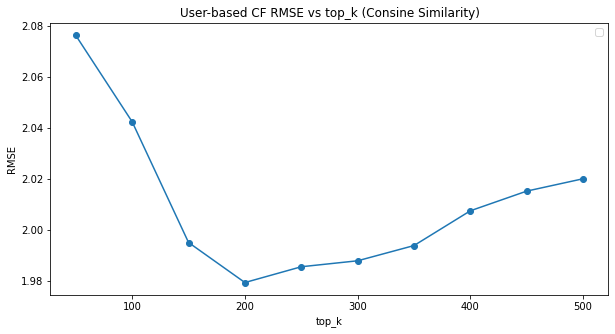

In [ ]:
top_k_list = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
rmse_history = []

for top_k in top_k_list:
    print("************ top_k=" + str(top_k) + " **************")
    M_predicted = fast_rate(train, mode='user', sim_type='cos', top_k=top_k)
    M_predicted = rescale_rating(M_predicted, 5, 1)
    current_rmse = rmse(test, M_predicted)
    print('User-based CF RMSE:'+str(current_rmse))
    rmse_history.append(current_rmse)

plt.figure(figsize=(10,5))
plt.plot(top_k_list, rmse_history, marker='o')
plt.title("User-based CF RMSE vs top_k (Consine Similarity)")
plt.xlabel("top_k")
plt.ylabel("RMSE")
plt.legend()
plt.show()

************ top_k=5 **************
Item-based CF RMSE:2.5524758213857743
************ top_k=10 **************
Item-based CF RMSE:2.3948507615920813
************ top_k=15 **************
Item-based CF RMSE:2.290968953724573
************ top_k=20 **************
Item-based CF RMSE:2.266957084893248
************ top_k=25 **************
Item-based CF RMSE:2.2391776819425475
************ top_k=50 **************
Item-based CF RMSE:2.2645220178980687
************ top_k=75 **************
Item-based CF RMSE:2.289898264952132
************ top_k=100 **************


No handles with labels found to put in legend.


Item-based CF RMSE:2.3091708456405873


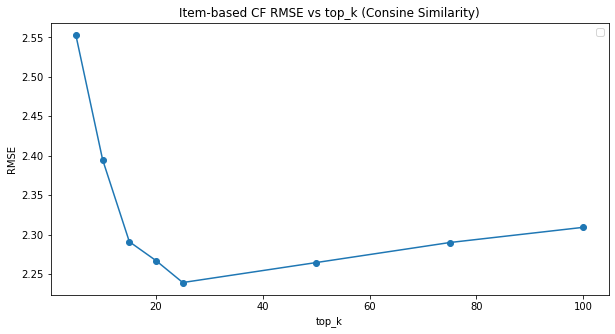

In [ ]:
top_k_list = [5, 10, 15, 20, 25, 50, 75, 100]
rmse_history = []

for top_k in top_k_list:
    print("************ top_k=" + str(top_k) + " **************")
    M_predicted = fast_rate(train, mode='item', sim_type='cos', top_k=top_k)
    M_predicted = rescale_rating(M_predicted, 5, 1)
    current_rmse = rmse(test, M_predicted)
    print('Item-based CF RMSE:'+str(current_rmse))
    rmse_history.append(current_rmse)

plt.figure(figsize=(10,5))
plt.plot(top_k_list, rmse_history, marker='o')
plt.title("Item-based CF RMSE vs top_k (Consine Similarity)")
plt.xlabel("top_k")
plt.ylabel("RMSE")
plt.legend()
plt.show()

### euclidean similarity, User/Item, choose *top_k*

In [ ]:
M_normalized = M - user_mean_ratings

M_normalized[M == 0] = 0

M_normalized = normalize(M_normalized, axis=1)

user_similarities = np.reshape(np.sum(M_normalized**2,axis=1),(M_normalized.shape[0],1))+ np.sum(M_normalized**2,axis=1)-2*M_normalized.dot(M_normalized.T)

In [ ]:
M_normalized = M - movie_mean_ratings

M_normalized[M == 0] = 0

M_normalized = normalize(M_normalized, axis=0)

movie_similarities = np.reshape(np.sum(M_normalized.T**2,axis=1),(M_normalized.T.shape[0],1))+ np.sum(M_normalized.T**2,axis=1)-2*M_normalized.T.dot(M_normalized)

************ top_k=5 **************
User-based CF RMSE:2.1559064127082848
************ top_k=10 **************
User-based CF RMSE:2.0683337386303715
************ top_k=25 **************
User-based CF RMSE:2.024742796438864
************ top_k=50 **************
User-based CF RMSE:1.9971347275046696
************ top_k=75 **************
User-based CF RMSE:1.9833965077536195
************ top_k=100 **************
User-based CF RMSE:1.9939819255999929
************ top_k=125 **************
User-based CF RMSE:1.9733739414512235
************ top_k=150 **************
User-based CF RMSE:1.9696222652220363
************ top_k=175 **************
User-based CF RMSE:1.967510880368115
************ top_k=200 **************
User-based CF RMSE:1.9614910428812469
************ top_k=250 **************
User-based CF RMSE:1.9681677339095616
************ top_k=300 **************
User-based CF RMSE:1.9770197214135752
************ top_k=350 **************
User-based CF RMSE:1.9831969841964006
************ top_k=4

No handles with labels found to put in legend.


User-based CF RMSE:2.020514750269726


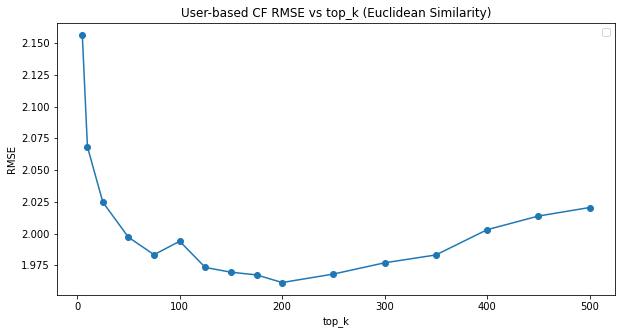

In [ ]:
top_k_list = [5, 10, 25, 50, 75, 100, 125, 150, 175, 200, 250, 300, 350, 400, 450, 500]
# top_k_list = [5500, 5700, 6000, 6010, 6020, 6030, 6035]
rmse_history = []

for top_k in top_k_list:
    print("************ top_k=" + str(top_k) + " **************")
    M_predicted = fast_rate(train, mode='user', sim_type='euc', top_k=top_k)
    M_predicted = rescale_rating(M_predicted, 5, 1)
    current_rmse = rmse(test, M_predicted)
    print('User-based CF RMSE:'+str(current_rmse))
    rmse_history.append(current_rmse)

plt.figure(figsize=(10,5))
plt.plot(top_k_list, rmse_history, marker='o')
plt.title("User-based CF RMSE vs top_k (Euclidean Similarity)")
plt.xlabel("top_k")
plt.ylabel("RMSE")
plt.legend()
plt.show()

************ top_k=1 **************
Item-based CF RMSE:1.8017665218655685
************ top_k=3 **************
Item-based CF RMSE:1.999054902161723
************ top_k=4 **************
Item-based CF RMSE:1.2716372429529352
************ top_k=5 **************
Item-based CF RMSE:1.7778726512084484
************ top_k=6 **************
Item-based CF RMSE:2.8132658686043612
************ top_k=7 **************
Item-based CF RMSE:2.812486128159701
************ top_k=8 **************
Item-based CF RMSE:2.8120313010068525
************ top_k=9 **************
Item-based CF RMSE:2.8121404846497313
************ top_k=10 **************
Item-based CF RMSE:2.8121692476702034
************ top_k=15 **************
Item-based CF RMSE:2.812980555420185
************ top_k=20 **************


No handles with labels found to put in legend.


Item-based CF RMSE:2.812426433459277


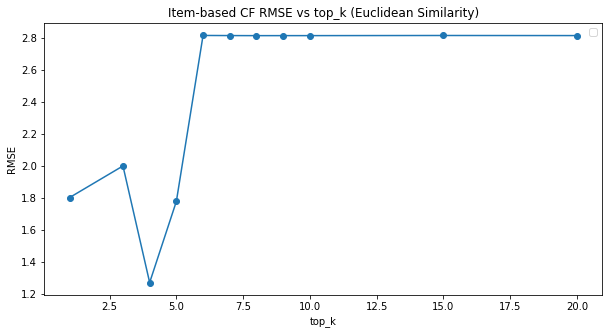

In [ ]:
# top_k_list = [5, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000, 1500]
top_k_list = [1, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
rmse_history = []

for top_k in top_k_list:
    print("************ top_k=" + str(top_k) + " **************")
    M_predicted = fast_rate(train, mode='item', sim_type='euc', top_k=top_k)
    M_predicted = rescale_rating(M_predicted, 5, 1)
    current_rmse = rmse(test, M_predicted)
    print('Item-based CF RMSE:'+str(current_rmse))
    rmse_history.append(current_rmse)

plt.figure(figsize=(10,5))
plt.plot(top_k_list, rmse_history, marker='o')
plt.title("Item-based CF RMSE vs top_k (Euclidean Similarity)")
plt.xlabel("top_k")
plt.ylabel("RMSE")
plt.legend()
plt.show()

### matrix factorization, choose k

In [ ]:
# k_list = [20]
# k_list = [5, 10, 15, 20, 25, 50, 75, 100, 125, 150, 175, 200, 250, 300]
k_list = [5, 10, 15, 20, 25, 50, 75, 100]
rmse_history = []
loss_history = []

for k in k_list:
    W = np.random.rand(num_user, k)

    H = np.random.rand(k, num_movie)

    Z = np.argwhere(train != 0)

    print("************ k=" + str(k) + " **************")

    loss_history,_,_ = matrix_fac(W, H, Z)

    M_predicted = np.around(np.dot(W, H), decimals=3)
    # M_predicted = rescale_rating(M_predicted, 5, 1)
    current_rmse = rmse(test, M_predicted)
    print('Model-based CF RMSE:'+str(current_rmse))
    rmse_history.append(current_rmse)

************ k=5 **************
CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.78 µs
Finished epoch 1 (1.4898351074469827)
Finished epoch 2 (0.9565915566922617)
Finished epoch 3 (0.8972462972868841)
Finished epoch 4 (0.8713179775355158)
Finished epoch 5 (0.8572510839529559)
Finished epoch 6 (0.8487404701000868)
Finished epoch 7 (0.8432110208885711)
Finished epoch 8 (0.8394255931876281)
Finished epoch 9 (0.8367253857315987)
Finished epoch 10 (0.8347329660436853)
Finished epoch 11 (0.833219729168536)
Finished epoch 12 (0.8320408960743721)
Finished epoch 13 (0.8311012800083583)
Finished epoch 14 (0.8303362154712759)
Finished epoch 15 (0.8297004366433312)
Finished epoch 16 (0.829161337297553)
Finished epoch 17 (0.8286947471208661)
Finished epoch 18 (0.8282822037683536)
Finished epoch 19 (0.8279091400855157)
Finished epoch 20 (0.8275636452530298)
Model-based CF RMSE:0.9210274059051677
************ k=10 **************
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs

No handles with labels found to put in legend.


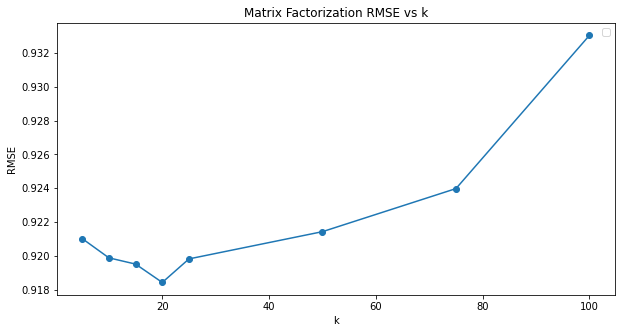

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(k_list, rmse_history, marker='o')
plt.title("Matrix Factorization RMSE vs k")
plt.xlabel("k")
plt.ylabel("RMSE")
plt.legend()
plt.show()

## Best RMSE results

In [66]:
M_normalized = M - user_mean_ratings
M_normalized[M == 0] = 0
M_normalized = normalize(M_normalized, axis=1)

user_similarities = np.reshape(np.sum(M_normalized**2,axis=1),(M_normalized.shape[0],1))+ np.sum(M_normalized**2,axis=1)-2*M_normalized.dot(M_normalized.T)

In [67]:
M_normalized = M - movie_mean_ratings
M_normalized[M == 0] = 0
M_normalized = normalize(M_normalized, axis=0)

movie_similarities = np.reshape(np.sum(M_normalized.T**2,axis=1),(M_normalized.T.shape[0],1))+ np.sum(M_normalized.T**2,axis=1)-2*M_normalized.T.dot(M_normalized)

In [68]:
user_M_predicted = fast_rate(train,mode='user',sim_type='euc',top_k=200)
item_M_predicted = fast_rate(train,mode='item',sim_type='euc',top_k=4)
user_M_predicted_ = rescale_rating(user_M_predicted, 5, 1)
item_M_predicted_ = rescale_rating(item_M_predicted, 5, 1)

In [69]:
k = 5
ini_W = np.random.rand(num_user, k)
ini_H = np.random.rand(k, num_movie)
ini_Z = np.argwhere(train != 0)
_,W,H = matrix_fac(ini_W, ini_H, ini_Z)
model_M_predicted = np.around(np.dot(W, H), decimals=3)
model_M_predicted_ = rescale_rating(model_M_predicted, 5, 1)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs
Finished epoch 1 (1.5062598115846262)
Finished epoch 2 (0.9593541182924517)
Finished epoch 3 (0.8981553432499669)
Finished epoch 4 (0.8715402498861233)
Finished epoch 5 (0.8571716448551888)
Finished epoch 6 (0.8485213578008357)
Finished epoch 7 (0.842927725775676)
Finished epoch 8 (0.8391147330035496)
Finished epoch 9 (0.8364045648318593)
Finished epoch 10 (0.8344099949746117)
Finished epoch 11 (0.8328972040600633)
Finished epoch 12 (0.8317185632464784)
Finished epoch 13 (0.8307772774335953)
Finished epoch 14 (0.8300077215410574)
Finished epoch 15 (0.8293639977016086)
Finished epoch 16 (0.8288130176051306)
Finished epoch 17 (0.8283301789492944)
Finished epoch 18 (0.8278965803601717)
Finished epoch 19 (0.8274971755141428)
Finished epoch 20 (0.8271195153456341)


In [70]:
print('User-based CF RMSE:'+str(rmse(test,user_M_predicted_)))

User-based CF RMSE:1.9614910428812469


In [71]:
print('Item-based CF RMSE:'+str(rmse(test,item_M_predicted_)))

Item-based CF RMSE:1.2716372429529352


In [72]:
print('Model-based CF RMSE:'+str(rmse(test,model_M_predicted_)))

Model-based CF RMSE:1.1037361140527553


## Recommendation of different methods

In [73]:
def get_recommendation_cf(M_predicted, user_id, topk=10, remove_rated=True):
    
    ### Get the user index
    user_idx = user_id2idx[user_id]
    recommendations = np.argsort(M_predicted[user_idx].squeeze())
    
    if remove_rated == True:
        already_rated_movies = np.where(M[user_idx] != 0)[0]
        recommendations = np.delete(recommendations, already_rated_movies)    

    recommendations = recommendations[::-1][:topk]
    return np.array([ movie_idx2id[r] for r in recommendations ])
    

In [74]:
def recommend_rank(user_id,M_predicted):
  for rank, movie_id in enumerate(get_recommendation_cf(M_predicted, user_id)):
      user_idx, movie_idx = user_id2idx[user_id], movie_id2idx[movie_id]
      title, genres = movie_dict[movie_id]
      avg_rating = movie_mean_ratings[movie_idx]
      pred_rating = M_predicted[user_idx,movie_idx]
      print('[Rank {} ({:.2f}/{:.2f})] {} {}'.format(rank+1, pred_rating, avg_rating, title, '/'.join(genres)))

In [75]:
test_user_id = 4033
print("User-based Recommendation for user " + str(test_user_id) + ":")
recommend_rank(test_user_id,user_M_predicted_)
print("Item-based Recommendation for user " + str(test_user_id) + ":")
recommend_rank(test_user_id,item_M_predicted_)
print("Matrix Factorization Recommendation for user " + str(test_user_id) + ":")
recommend_rank(test_user_id,model_M_predicted_)
print("Singularity Value Decomposition Recommendation for user " + str(test_user_id) + ":")
recommend_rank(test_user_id,UsV)

User-based Recommendation for user 4033:
[Rank 1 (4.75/4.48)] Raiders of the Lost Ark (1981) action/adventure
[Rank 2 (4.67/4.32)] Matrix, The (1999) thriller/action/sci-fi
[Rank 3 (4.64/4.34)] Saving Private Ryan (1998) drama/action/war
[Rank 4 (4.59/4.45)] Star Wars: Episode IV - A New Hope (1977) action/adventure/fantasy/sci-fi
[Rank 5 (4.56/4.29)] Star Wars: Episode V - The Empire Strikes Back (1980) drama/war/adventure/action/sci-fi
[Rank 6 (4.53/4.02)] Star Wars: Episode VI - Return of the Jedi (1983) war/romance/adventure/action/sci-fi
[Rank 7 (4.45/4.23)] Braveheart (1995) drama/action/war
[Rank 8 (4.37/4.06)] Terminator 2: Judgment Day (1991) thriller/action/sci-fi
[Rank 9 (4.31/4.09)] Forrest Gump (1994) comedy/romance/war
[Rank 10 (4.31/4.12)] Die Hard (1988) thriller/action
Item-based Recommendation for user 4033:
[Rank 1 (4.27/1.77)] Police Academy 5: Assignment: Miami Beach (1988) comedy
[Rank 2 (4.26/1.91)] Police Academy 4: Citizens on Patrol (1987) comedy
[Rank 3 (4.25

In [87]:
# user-profile-euclidean
test_user_id = 4033
print("User-Profile Similarity Recommendation for user " + str(test_user_id) + ":")
recommend_rank(test_user_id,M_predicted_scale)
# movie-profile-tf-idf
test_user_id = 4033
print("Movie-Profile Similarity Recommendation for user " + str(test_user_id) + ":")
recommend_rank(test_user_id,M_predicted_tfidf)

User-Profile Similarity Recommendation for user 4033:
[Rank 1 (2.07/4.45)] Star Wars: Episode IV - A New Hope (1977) action/adventure/fantasy/sci-fi
[Rank 2 (2.07/4.02)] Star Wars: Episode VI - Return of the Jedi (1983) war/romance/adventure/action/sci-fi
[Rank 3 (2.07/4.29)] Star Wars: Episode V - The Empire Strikes Back (1980) drama/war/adventure/action/sci-fi
[Rank 4 (2.07/4.15)] Terminator, The (1984) thriller/action/sci-fi
[Rank 5 (2.07/4.35)] Silence of the Lambs, The (1991) drama/thriller
[Rank 6 (2.07/4.32)] Matrix, The (1999) thriller/action/sci-fi
[Rank 7 (2.07/3.99)] Back to the Future (1985) comedy/sci-fi
[Rank 8 (2.07/3.68)] Who Framed Roger Rabbit? (1988) film-noir/animation/adventure
[Rank 9 (2.07/4.32)] American Beauty (1999) drama/comedy
[Rank 10 (2.07/4.10)] Fugitive, The (1993) thriller/action
Movie-Profile Similarity Recommendation for user 4033:
[Rank 1 (3.23/3.09)] Tequila Sunrise (1988) thriller/action/romance
[Rank 2 (3.23/3.57)] Speed (1994) thriller/action/rom

# Summary

The common goal of CF-based methods is to predict unknown ratings based on the available ratings, and there a various methods to accomplish this. In this notebook we looked at implementations of the memory-based and model-based approach. Of course, we covered only the most basic steps, and practical implementations of recommender systems use a variety of extension to further improve the recommendations.

Most basically, one can combine different methods (including content-based ones) to utilize the different benefits and curb their in individual drawbacks. In general, what defines a good set of recommendations to often very subjective and there a many different tweaks to recommender systems to improve users' experience and satisfaction.